In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = pd.read_csv("./Data/train.csv")
mnist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


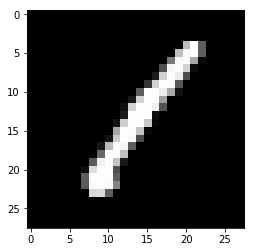

In [3]:
# showing only image
single_image = np.array(mnist.iloc[0:1,1:].values)
single_image = single_image.reshape(28, 28)
plt.imshow(single_image, cmap="gist_gray")

In [4]:
x_data = mnist.drop("label", axis=1)
x_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# normalize pixel values
x_data = x_data / 255
x_data.iloc[:1,:].values.max()

1.0

In [6]:
y_labels = mnist["label"]
y_labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [7]:
y_labels = pd.get_dummies(y_labels)

In [8]:
y_labels.head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [9]:
x_data = np.array(x_data.values)
x_data.shape

(42000, 784)

In [10]:
x_train = x_data[:37000]
x_train.shape

(37000, 784)

In [11]:
x_validation = x_data[37000:]
x_validation.shape

(5000, 784)

In [12]:
y_train = y_labels[:37000].values
y_train.shape

(37000, 10)

In [13]:
y_validation = y_labels[37000:].values
y_validation.shape

(5000, 10)

In [14]:
# Weight initialization function
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return (tf.Variable(init_random_dist))

In [15]:
# Bias initialization function
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [16]:
# 2d convolution function which is already performed by tf
def conv2d(x, W):
    # x => input tensor ==> [batch, H, W, Channels]
    # W => kernel => [filter height, filter width, # of channels in, # channels out]
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding="SAME")
# padding with SAME adds zeros to the end
# Strides is how you want to move in the whole thing [batch, height, width, channel]

In [17]:
# Pooling function in this case max pooling which gets the max value and is a 2x2 kernel
def max_pool_2by2(x):
    # x=> input => [batch, h, w, c]
    return (tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME"))
# Ksize = size of the window which makces the pooling [batch, h, w, c] => here 1 is like pasing all 2 is reducing
    # We only want to reduce the height and width of the image, that is why we use 
    # [1 in batch, 2 in height, 2 in width, 1 in channel]
#  Stride here is [1, 2, 2, 1] because we want to shorten the image so we jump 2 by 2 pixels in the image

In [18]:
# convolutional layer function
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]]) 
    # we take the third one because that is the number of channels we are using
    # is not really intuitive but the channels is like the number of features
    # first is going to be 1 then more
    return (tf.nn.relu(conv2d(input_x, W)+b))

In [19]:
# normal layaer (fully connected layer)
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1]) 
    # we use the index one beacause 0 is the batch size and 1 is the number of nodes
    W = init_weights([input_size, size])
    b = init_bias([size])
    return (tf.matmul(input_layer, W)+b)
# simple weighted sum

In [20]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [21]:
# image layer => change the image to a 28 by 28 grid again
x_image = tf.reshape(x, [-1, 28, 28, 1])
# the -1 is a special value in the reshape function which means that the value is going to be computed so that 
# everythinh else in the array remains constant
#If one component of shape is the special value -1, the size of that dimension is computed so that 
# the total size remains constant

In [22]:
# First convolutional layer
convo_1 = convolutional_layer(x_image, shape=[5,5,1,32]) 
#we are using a 5x5 filter with 1 channel in and 32 features out
# 32 feaures out means that we are going to apply the filter to the whole image 32 times
# First pooling layer
convo_1_pooling = max_pool_2by2(convo_1)

In [23]:
# Convolutional layer 2
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
# 32 because we are getting that many features from the past convo and 64 is the number we want to get out of it
# remember we get those features by the matrix multiplication
convo_2_pooling = max_pool_2by2(convo_2)

In [24]:
# now we flatten the result
# it is important to notice that we have a 7by7 image right now because the convolution has padding,
# which makes the image to just go throuhg the layer withou loosing its size
# So the only thing changing the size are the pooling layer which diivide the width and height by 2 and then again by 2
convo_2_flat = tf.reshape(convo_2_pooling,[-1, 7*7*64])
# 7*7 because of the width and height and 64 because of the channels

In [25]:
# now we put the normal full layer
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))
# 1024 is just the number of nodes we want on the next layer, which is just based in the model we are creating

In [26]:
# Regularization function which is dropout
hold_prob = tf.placeholder(tf.float32) # just keeps our probability of a node staying
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)
# tf function only need the probability and the layer you want to make dropout to

In [27]:
# final layer to reduce to number of results
y_pred = normal_full_layer(full_one_dropout, 10)
# we only want ten results one for each digit

In [28]:
# error funcitons
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred))

In [29]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [30]:
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar("accuracy", acc)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [31]:
#variable initializer
init = tf.global_variables_initializer()

In [32]:
#savers
saver = tf.train.Saver()

In [33]:
#summaries for tensorboard
merged_summary_op = tf.summary.merge_all() # this will get all the summaries from the graph and join them

In [34]:
steps = 1000
batch_size = 128

with tf.Session() as sess:
    sess.run(init)
    
    # to use tensorboard you need to have a file writer to keep the logs
    train_writer = tf.summary.FileWriter("./tensorboard/train", graph=tf.get_default_graph())
    validation_writer = tf.summary.FileWriter("./tensorboard/validation", graph=tf.get_default_graph())
    
    for i in range(steps + 1):
        
        rand_ind = np.random.randint(len(x_train), size=batch_size)
        # Here we add hold_prob to our feed dictionary because it is a placeholder
        feed = {x:x_train[rand_ind], y_true:y_train[rand_ind], hold_prob:0.5}
        sess.run(train, feed_dict=feed)
        
        
        # When runnining you need to append logs for tensorboard
        if i%50 == 0:
            summary = sess.run(merged_summary_op,
                                      {x:x_train[rand_ind], y_true:y_train[rand_ind], hold_prob:1.0})
            train_writer.add_summary(summary, i)
            train_writer.flush()
            summary = sess.run(merged_summary_op,
                                      {x:x_validation, y_true:y_validation, hold_prob:1.0})
            validation_writer.add_summary(summary, i)
            validation_writer.flush()
            print("saved summary in step #{}".format(i))
    
    saver.save(sess, "cnn_model/cnn.ckpy")

saved summary in step #0
saved summary in step #50
saved summary in step #100
saved summary in step #150
saved summary in step #200
saved summary in step #250
saved summary in step #300
saved summary in step #350
saved summary in step #400
saved summary in step #450
saved summary in step #500
saved summary in step #550
saved summary in step #600
saved summary in step #650
saved summary in step #700
saved summary in step #750
saved summary in step #800
saved summary in step #850
saved summary in step #900
saved summary in step #950
saved summary in step #1000


### Predictions


In [35]:
test_data = pd.read_csv("./Data/test.csv")
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
test_data.iloc[0:1,:].values.max()

255

In [37]:
test_data = test_data / 255

In [38]:
test_data.iloc[0:1,:].values.max()

1.0

In [39]:
test_data = test_data.values
test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
test_data.shape

(28000, 784)

In [41]:
with tf.Session() as sess:
    saver.restore(sess, "cnn_model/cnn.ckpy")
    
    prediction = y_pred
    predictions = sess.run(prediction, feed_dict={x:test_data, hold_prob:1.0})
    result = []
    decode = tf.argmax(predictions, axis=1)
    result = sess.run(decode)
    print (result)

INFO:tensorflow:Restoring parameters from cnn_model/cnn.ckpy
[2 0 9 ... 3 9 2]


In [42]:
result_df = pd.DataFrame(result, columns=["Label"], dtype=int)
result_df.index +=1

In [43]:
result_df.index.name = "ImageId"

In [44]:
result_df.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [45]:
result_df.to_csv("./result_for_cnn.csv")

In [46]:
#for tensorboard on terminal home directory
# tensorboard --logdir=./tensorboard 